# Assignment 5: DA24C005

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

In [43]:
df = pd.read_csv("nursery.data", header = None)

In [44]:
df.columns = ["parents", "has_nurs", "form", "children", "housing", "finance", "social", "health", "class"]

In [45]:
df.head(5)

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [46]:
df.describe()

,parents,has_nurs,form,children,housing,finance,social,health,class
count,12960,12960,12960,12960,12960,12960,12960,12960,12960
unique,3,5,4,4,3,2,3,3,5
top,usual,proper,complete,1,convenient,convenient,nonprob,recommended,not_recom
freq,4320,2592,3240,3240,4320,6480,4320,4320,4320


In [47]:
df['class'].value_counts()

,count
class,
not_recom,4320
priority,4266
spec_prior,4044
very_recom,328
recommend,2


There are 5 classes in this dataset. Since, we require a 3 class dataset, we collapse spec_prior, recommend, and very_recom into the "recommend" class.

In [48]:
df["class"] = df['class'].replace({"spec_prior":"recommend", "very_recom": "recommend" })

In [49]:
df["class"].value_counts()

,count
class,
recommend,4374
not_recom,4320
priority,4266


**Splitting the dataset into train and test sets in the ratio 80-20.**

We do not include validation in the above ratio beacause when using Grid Search, it automatically uses 20% of the training data during the 5 folds of cross-validation

In [50]:
def split_dataset(df, testratio = 0.2):
  x = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=testratio)
  return xtrain, xtest, ytrain, ytest

##**Creating a Class called classifier_accuracy**

This greatly helps in code reusability as most of the code for evaluating performance (based on accuracy) of the different classifiers is quite similar.

We use grid search for hyperparameter tuning to evaluate all possible combinations of hyperparameters. It explores the parameters by searching through the specified parameter grid for best performance.


In [51]:
class classifier_accuracy:
  """Initializing parameters:"""

  def __init__(self, hyp_params, classifier, folds = 5):
    self.hyp_params = hyp_params      # dictionary which contains the hyper-parameters relevant to the classifier
    self.folds = folds                # Specifies the no of folds for cross-validation
    self.classifier_type = classifier  # type of classifier to use ('logistic', 'knn', 'decision_tree')
    self.classifier = self._initialize_classifier() # creates an object of the classifier
    self.accuracy_list = []            # a list to store accuracies calculated during different folds of cross-validation

  def _initialize_classifier(self):

# Initializes the classifier based on the type of the classifier

    if self.classifier_type == 'dec_tree':
        return DecisionTreeClassifier()
    elif self.classifier_type == 'log_reg':
        return LogisticRegression()
    elif self.classifier_type == 'knn':
        return KNeighborsClassifier()

  def evaluate(self, encoded_df, folds = 5):

# Evaluates the accuracy of the classifier using cross-validation and hyperparameter tuning

    for i in range(folds):
      xtrain, xtest, ytrain, ytest = split_dataset(encoded_df)
      gridsearch = GridSearchCV(estimator=self.classifier, param_grid=self.hyp_params, scoring='accuracy', cv=self.folds)
      gridsearch.fit(xtrain, ytrain)
      best_params = gridsearch.best_params_
      print("Optimal parameters:", best_params)
      best_model = gridsearch.best_estimator_
      predictions = best_model.predict(xtest)
      accuracy = accuracy_score(ytest, predictions)
      print("Testing accuracy:", accuracy)
      self.accuracy_list.append(accuracy)

  def get_accuracy_list(self):

    #returns a list containing accuracies calculated during different folds of cross-validation

    return self.accuracy_list

  def calculate_mean_var(self):

        # Calculates and prints the mean and variance of accuracies

        accuracy_list = self.get_accuracy_list()
        accuracy_mean = np.mean(accuracy_list)
        accuracy_var = np.var(accuracy_list)
        acc_percent = [100 * acc for acc in accuracy_list]
        accuracy = np.mean(acc_percent)
        var_accuracy = np.var(acc_percent)

        print(f"Mean accuracy: {accuracy_mean}")
        print(f"Variance of accuracy: {accuracy_var}")
        print(f"Accuracy (%): {accuracy}")
        print(f"Variance of accuracy(%): {var_accuracy}")
        return accuracy, var_accuracy


Stores the hyperparameters of three different classifiers (knn, logistic_regression and decision-tree) in a dictionary format for tuning the classifiers

In [52]:
param_grid = {'knn':{
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}, 'dec_tree': {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'criterion': ['gini', 'entropy'] # Impurity measurement method
},"log_reg":{
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear']
}}

## **Decision Tree with categorical features**

In [53]:
encoded_df = df.copy()
label_encoder = LabelEncoder()
for feature in encoded_df.columns[:-1]:
    encoded_df[feature] = label_encoder.fit_transform(encoded_df[feature])

In [54]:
encoded_df.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,2,3,0,0,0,0,0,2,recommend
1,2,3,0,0,0,0,0,1,priority
2,2,3,0,0,0,0,0,0,not_recom
3,2,3,0,0,0,0,2,2,recommend
4,2,3,0,0,0,0,2,1,priority


In [36]:
decision_tree = classifier_accuracy(hyp_params=param_grid["dec_tree"], classifier='dec_tree', folds = 5)
decision_tree.evaluate(encoded_df)

Optimal parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9969135802469136
Optimal parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9949845679012346
Optimal parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9957561728395061
Optimal parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9926697530864198
Optimal parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9938271604938271


**Reporting Mean and variance of accuracy of decision tree**

In [37]:
dec_tree_mean, dec_tree_var = decision_tree.calculate_mean_var()

Mean accuracy: 0.9948302469135802
Variance of accuracy: 2.1790695016003044e-06
Accuracy (%): 99.48302469135801
Variance of accuracy(%): 0.021790695016003298


## **Decision Tree (categorical features in one-hot encoded form)**

In [38]:
onehot_encoder = OneHotEncoder(sparse = False, drop = 'first')

x_onehot_encoded = onehot_encoder.fit_transform(df.iloc[:, :-1])

oh_encoded_df = pd.DataFrame(x_onehot_encoded, columns=onehot_encoder.get_feature_names_out(df.columns[:-1]), index=df.index)

oh_encoded_df["class"] = df["class"]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [39]:
oh_encoded_df.head()

,parents_pretentious,parents_usual,has_nurs_improper,has_nurs_less_proper,has_nurs_proper,has_nurs_very_crit,form_completed,form_foster,form_incomplete,children_2,children_3,children_more,housing_critical,housing_less_conv,finance_inconv,social_problematic,social_slightly_prob,health_priority,health_recommended,class
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,recommend
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,priority
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,not_recom
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,recommend
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,priority


In [40]:
onehot_dec_tree = classifier_accuracy(hyp_params=param_grid['dec_tree'], classifier='dec_tree')
onehot_dec_tree.evaluate(oh_encoded_df)

Optimal parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9953703703703703
Optimal parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.996141975308642
Optimal parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9903549382716049
Optimal parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9934413580246914
Optimal parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Testing accuracy: 0.9888117283950617


**Reporting Mean and variance of accuracy of decision tree (one-hot encoded features)**

In [41]:
oh_dtree_mean, oh_dtree_var = onehot_dec_tree.calculate_mean_var()

Mean accuracy: 0.992824074074074
Variance of accuracy: 8.013736473098693e-06
Accuracy (%): 99.2824074074074
Variance of accuracy(%): 0.0801373647309863


## **Logistic Regression with L1 regularization**

In [55]:
log_reg = classifier_accuracy(hyp_params=param_grid['log_reg'], classifier='log_reg')
log_reg.evaluate(oh_encoded_df)

Optimal parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Testing accuracy: 0.9104938271604939
Optimal parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Testing accuracy: 0.9185956790123457


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimal parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Testing accuracy: 0.9135802469135802
Optimal parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Testing accuracy: 0.9085648148148148
Optimal parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Testing accuracy: 0.9147376543209876


**Reporting Mean and variance of accuracy of logistic regression (l1 regularisation)**

In [56]:
log_reg_mean, log_reg_var = log_reg.calculate_mean_var()

Mean accuracy: 0.9131944444444444
Variance of accuracy: 1.2086095869532217e-05
Accuracy (%): 91.31944444444443
Variance of accuracy(%): 0.12086095869531979


## **k-Nearest Neighbors**

In [57]:
knn = classifier_accuracy(hyp_params=param_grid['knn'], classifier='knn')
knn.evaluate(encoded_df)

Optimal parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Testing accuracy: 0.9560185185185185
Optimal parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Testing accuracy: 0.9602623456790124
Optimal parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Testing accuracy: 0.9618055555555556
Optimal parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Testing accuracy: 0.9652777777777778
Optimal parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Testing accuracy: 0.9560185185185185


**Reporting Mean and variance of accuracy of k-nearest neighbors classifier**

In [58]:
knn_mean, knn_var = knn.calculate_mean_var()

Mean accuracy: 0.9598765432098764
Variance of accuracy: 1.2562395214144322e-05
Accuracy (%): 95.98765432098766
Variance of accuracy(%): 0.12562395214144512


## **Visualising Model performance (mean, variance of accuracy) of different classifiers**

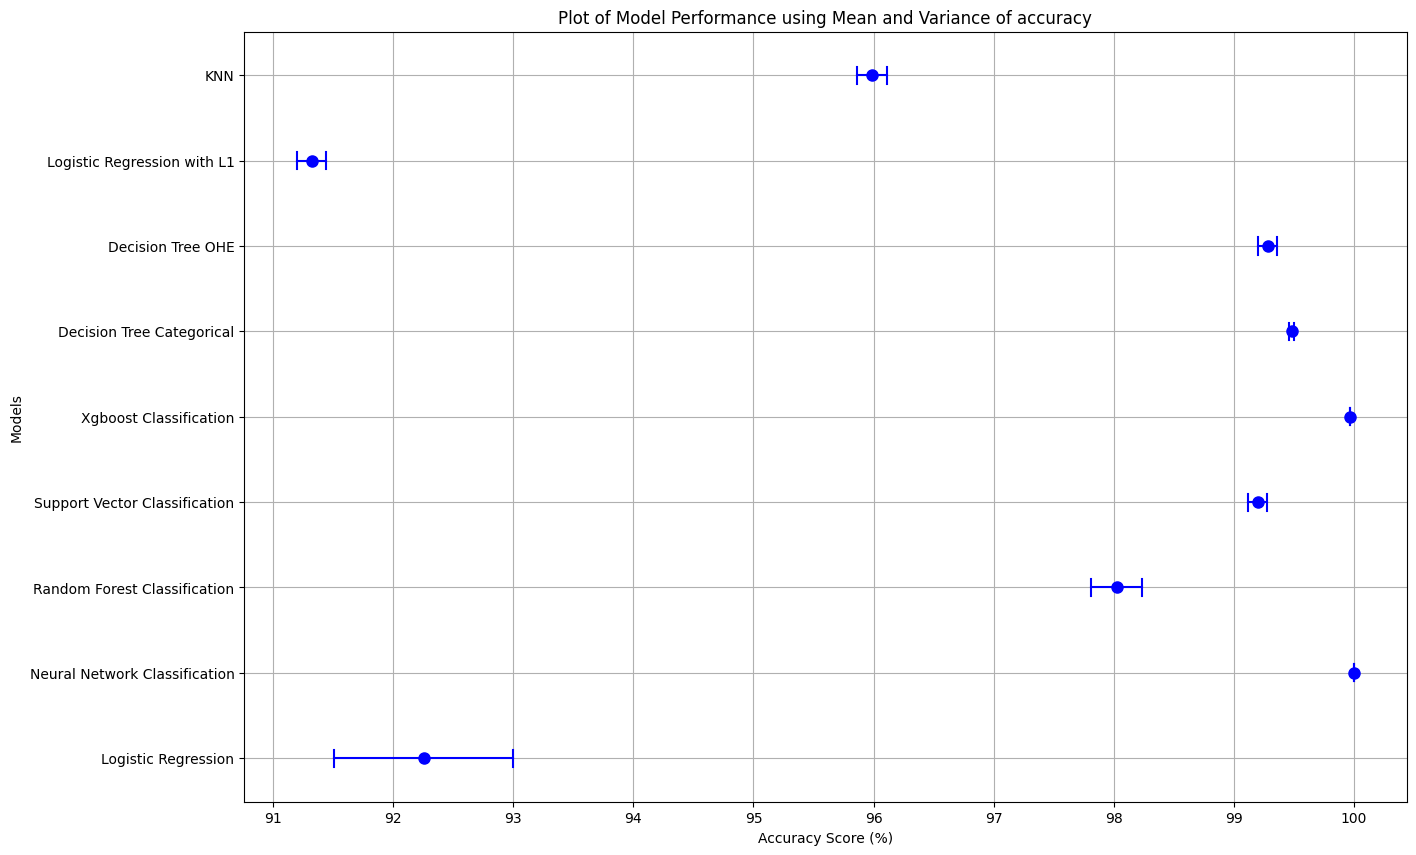

In [59]:
models = ['Logistic Regression', 'Neural Network Classification', 'Random Forest Classification',
          'Support Vector Classification', 'Xgboost Classification', 'Decision Tree Categorical', 'Decision Tree OHE', 'Logistic Regression with L1',
          'KNN']

means = [92.253, 100, 98.025, 99.198, 99.969,  dec_tree_mean, oh_dtree_mean, log_reg_mean, knn_mean]
variances = [0.7465, 0, 0.2144, 0.0767, 0.00096, dec_tree_var, oh_dtree_var, log_reg_var, knn_var]

plt.figure(figsize=(15, 10))

plt.plot(means, range(len(models)), 'o', color='b', markersize=8, label='Mean Accuracy')

for i in range(len(means)):
    mean = means[i]
    variance = variances[i]
    plt.plot([mean - variance, mean + variance], [i, i], 'b-')
    plt.plot([mean - variance, mean - variance], [i - 0.1, i + 0.1], 'b-')
    plt.plot([mean + variance, mean + variance], [i - 0.1, i + 0.1], 'b-')

plt.yticks(range(len(models)), models)
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Models')
plt.xticks(range(91, 101))
plt.title('Plot of Model Performance using Mean and Variance of accuracy')
plt.grid(True)

plt.show()


# **Task 2**

## **Constructing a bipolar_sigmoid(x) using unipolar sigmoid**

Unipolar Sigmoid Function is given by $ \sigma(x) = \frac{1}{1 + e^{-x}} $

The range of $\sigma$ is  $[0, 1]$.

To generate the bipolar sigmoid function, we need to obtain output values in the range $[-1, 1]$.

Hence, we perform the following transformation using scale and shift method:

   $ \sigma_{\text{bipolar}}(x) = 2 * \sigma_{\text{unipolar}}(x) - 1 $

$ \sigma_{\text{bipolar}}(x) = \frac{2}{1 + e^{-x}} - 1 $





In [60]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def bipolar_sigmoid(x):
  return 2 * sigmoid(x) - 1

## **Compare tanh(x) vs bipolar_sigmoid(x)**

The $tanh(x)$ function is a scaled and shifted version of the sigmoid function.

It is a bipolar normalizer whose formula is given by:

$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$


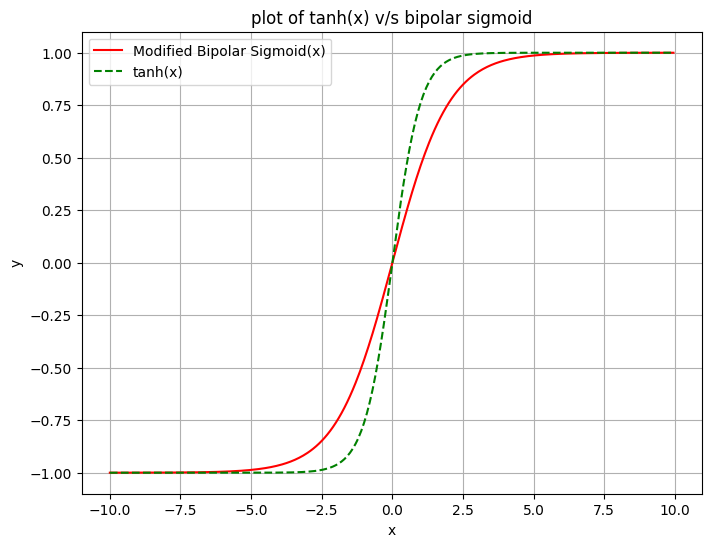

In [61]:
x = np.arange(-10, 10, 0.05)
y_bipolar_sigmoid = bipolar_sigmoid(x)
y_tanh = np.tanh(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y_bipolar_sigmoid, label='Modified Bipolar Sigmoid(x)', color='red')
plt.plot(x, y_tanh, label='tanh(x)', linestyle='--', color='green')
plt.title('plot of tanh(x) v/s bipolar sigmoid')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## **Parameterization & plotting the values of $ \sigma_{\text{bipolar}}(ax)$ and $ tan(ax)$ using different values of a**

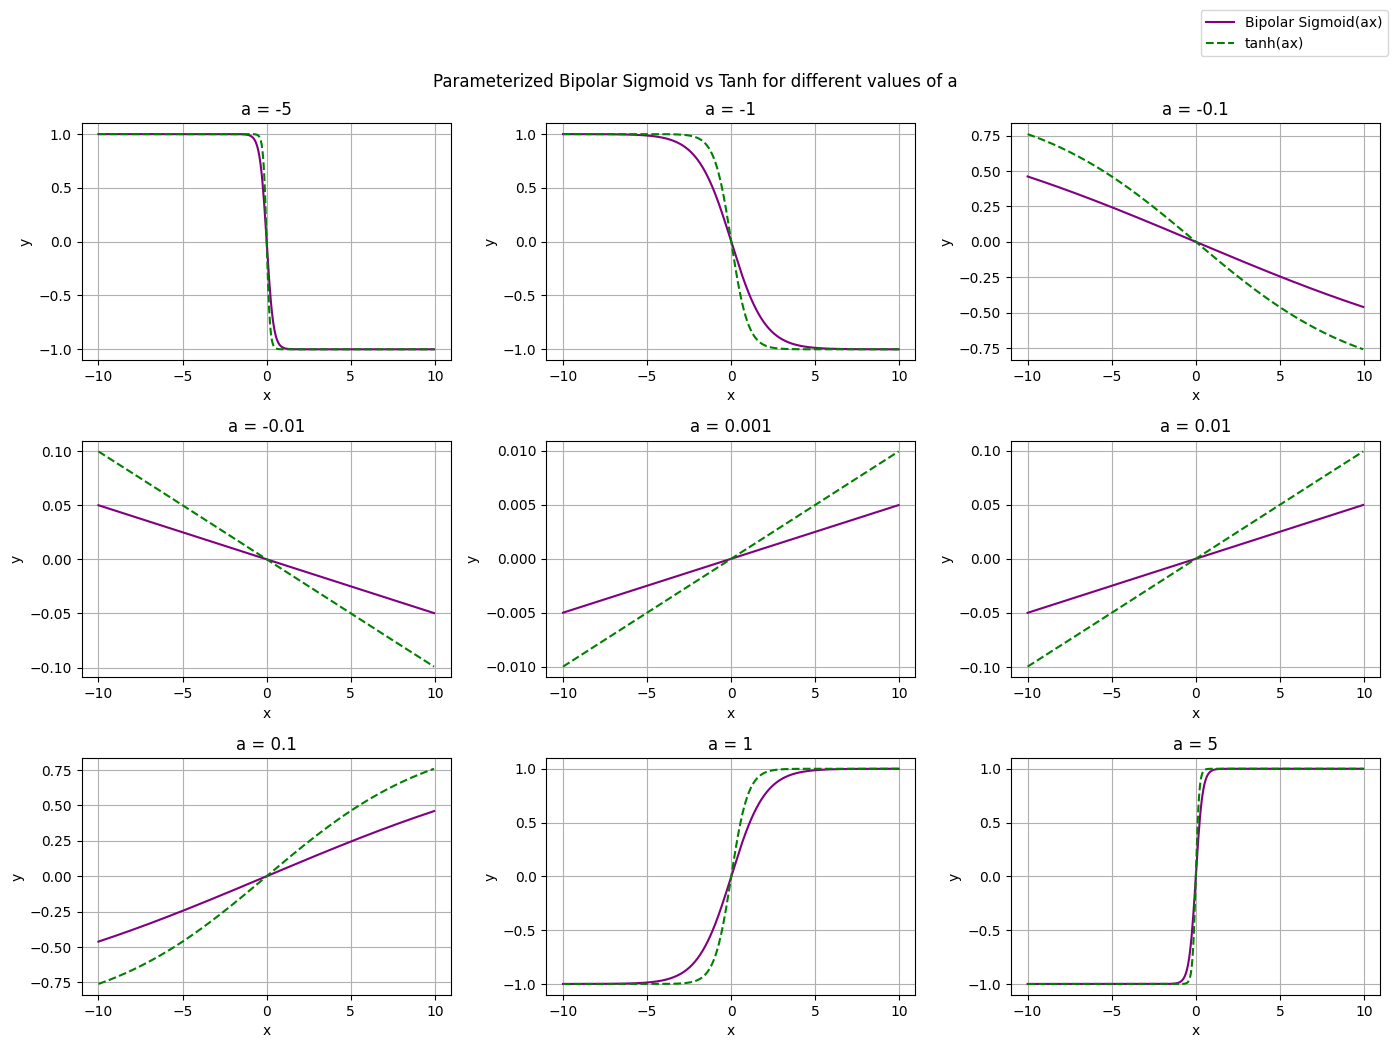

In [62]:
x = np.arange(-10, 10, 0.05)
a_values = [-5, -1, -0.1, -0.01, 0.001, 0.01, 0.1, 1, 5]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))
axes = axes.flatten()


for i in range(len(a_values)):
  a = a_values[i]
  y_bipolar_sigmoid = bipolar_sigmoid(a * x)
  y_tanh = np.tanh(a * x)

  line1, = axes[i].plot(x, y_bipolar_sigmoid, label='Bipolar Sigmoid(ax)', color='purple')
  line2, = axes[i].plot(x, y_tanh, linestyle='--', label='tanh(ax)', color='green')

  axes[i].set_title(f'a = {a}')
  axes[i].set_xlabel('x')
  axes[i].set_ylabel('y')
  axes[i].grid(True)

labels = [line1.get_label(), line2.get_label()]

fig.suptitle("Parameterized Bipolar Sigmoid vs Tanh for different values of a")

fig.legend(labels=labels, loc='upper right', bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.show()

## **Evaluating the linear range of $x$ for each value of $a$  for $\sigma_{\text{bipolar}}(ax)$**

- When a attains relatively larger values $(a = -5,5)$, the sigmoid function responds very sharply around $x = 0$. The function is linear only for a very short range around 0

- When $(a = -1, 1)$ the function transitions in a smoother manner and achieves linearity for a relatively longer range

- When a attains values close to $0$ $(a=0.1, 0.01, -0.1, -0.01)$ the function is linear for a broad range of x